# ARIMA Lab    

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
#Check the data have missed values and type
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [3]:
# make "store1" asignment
store1 = data['Store'] == 1
data = data[store1]
data

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-08-31,1,99,20.06,False
2012-09-07,1,99,0.05,True
2012-09-14,1,99,0.03,False


In [4]:
# Weekly_Sales DataFrame for aggregating
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())
Weekly_Sales 

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

Text(0.5, 1.0, 'Walmart Weekly Sales')

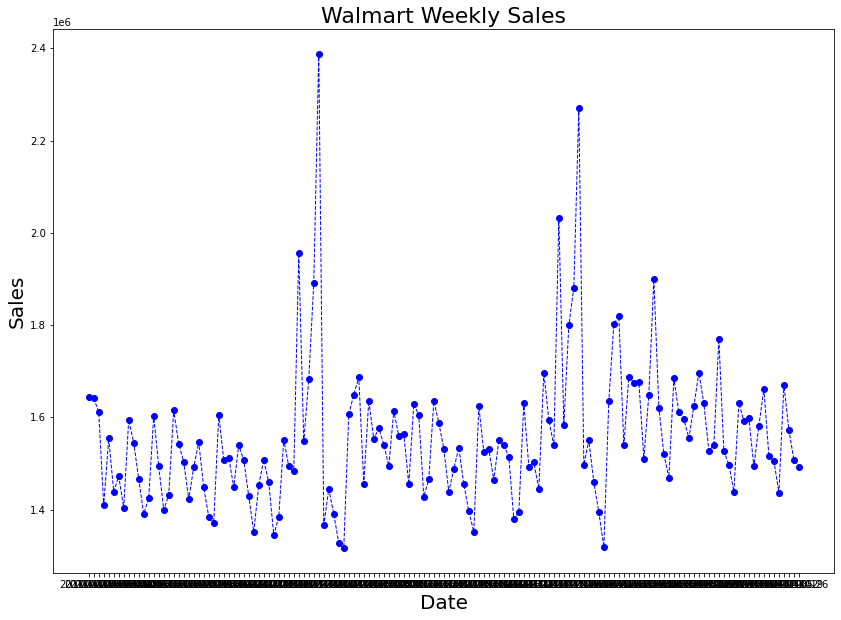

In [5]:
# Create line plot
plt.figure(figsize=(14,10))

plt.plot(Weekly_Sales, c ='blue', marker='o', linestyle='dashed', linewidth=1, markersize=6)

# Set labels and title.
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.title('Walmart Weekly Sales', fontsize=22)

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [6]:
# The rolling mean of first week, four weeks(week4) and quartely (52 weeks/4 = 13 weeks)
rollweek1  = Weekly_Sales.rolling(window = 1).mean()
rollweek4  = Weekly_Sales.rolling(window = 4).mean()
rollweek13 = Weekly_Sales.rolling(window = 13).mean()

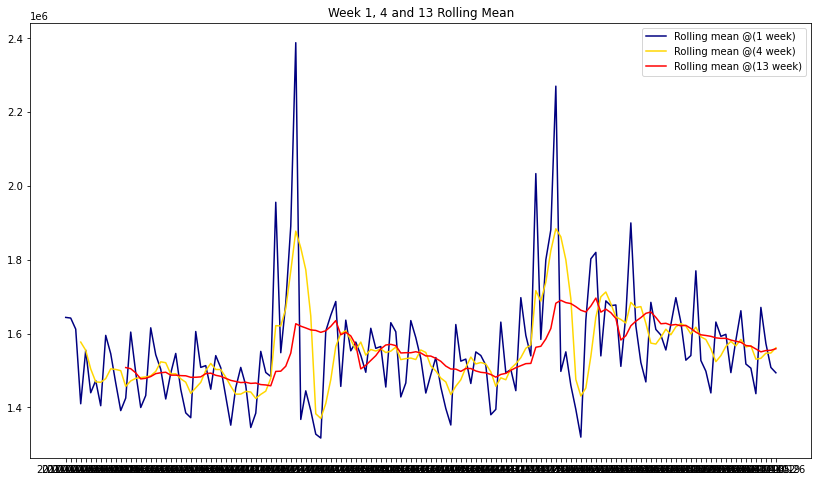

In [7]:
# The line plot
plt.figure(figsize=(14,8))
plt.plot(rollweek1, color='navy', label='Rolling mean @(1 week)')
plt.plot(rollweek4, color='Gold', label='Rolling mean @(4 week)')
plt.plot(rollweek13, color='red', label='Rolling mean @(13 week)')

plt.legend(loc='upper right')

plt.title("Week 1, 4 and 13 Rolling Mean")
plt.show()

**2c. What can you say about patterns in the data based on the rolling mean plot above?**

Answer:
- There are two highly spiked graph regions following dropped values. It may indicate people go to the supermarket to buy a lot and decrease buying any more. Most likely it is a time of holiday or discount season. The week1 rolling mean clearly shows the details of buying but the quarterly removed most of the spiked and become closely smooth graph.


#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [8]:
#Autocorrelation in the first week
week1_autocorr=Weekly_Sales["Weekly_Sales"].autocorr(lag=1)
week1_autocorr

0.3021582794113126

In [9]:
round (week1_autocorr, 3)

0.302

In [10]:
#Autocorrelation in the two weeks
week2_autocorr=Weekly_Sales["Weekly_Sales"].autocorr(lag=2)
round(week2_autocorr, 3)

0.127

In [11]:
#Autocorrelation in the in ayear
week52_autocorr=Weekly_Sales["Weekly_Sales"].autocorr(lag=52)
round(week52_autocorr, 3)

0.895

**3b. What can you say about the series based on these autocorrelations?**

Answer:
- The first week autocorrelation shows better effect on sales as compared the prior week and also the second week too. However, the 52 weeks sale shows much strong correlation than all the other. This may be influenced by season sales increment in the year.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

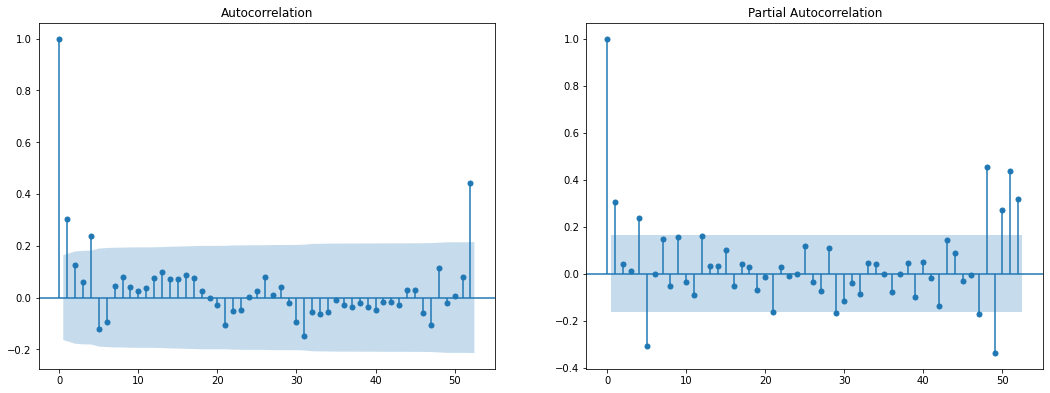

In [12]:
# Plote of Autocorrelation and Partial Autocorrelation
fig = plt.figure(figsize=(18,14))
ax1 = fig.add_subplot(221)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(222)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);

### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:
- The blue shade shows a 95% confidence interval and the points in the shade considered as a noise. The greatest interest is the points outside the blue space. The fist point doesn’t have meaning since it is the correlation of itself in the first week sales that is why the value is 1. At the first and fifth lag points there is certain value of correlation between current and prior sales in a week and month, respectively both the ACF and PACF. There are some strong positive correlations at lags in the end points that may be lay closer to 52 (a year) both in both the ACF and PACF. Typically, PACF have much correlation point around lag 52 than ACF.


**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer:
- The correlation at the first week, the fifth weeks and closer to a year end points (including 52 weeks) help to evaluate the $p$ values and checking the fitting of the models.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data. You can do this using `train_test_split` with a specific parameter, or can manually define it how it is set up below.

In [13]:
print(f"Total observations: {len(Weekly_Sales)}")
print(f"Training observations: {round(len(Weekly_Sales) * 0.75)}")
print(f"Testing observations: {round(len(Weekly_Sales) * 0.25)}")

train = Weekly_Sales.iloc[:108,]

test = Weekly_Sales.iloc[108:,]

Total observations: 143
Training observations: 107
Testing observations: 36


#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [14]:
# Train values and dates in the data
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Fit the model
AR1 = AR(train_values, train_dates).fit()
AR1

In [15]:
# Test values and dates in the data.
test_values = test['Weekly_Sales'].values
test_dates  = test.index
# To make prediction assign start and end dates
start = test.index[0]
end = test.index[-1]

In [16]:
# make predictions 
AR1_pre = AR1.predict(start = start, end = end)
AR1_pre

array([1640487.58718909, 1534725.41431026, 1604942.31303488,
       1468770.54805647, 1579684.47581457, 1542231.06652534,
       1578813.08064175, 1525975.32002629, 1551847.11622191,
       1556352.87810132, 1578451.34397438, 1553920.45384082,
       1561671.57940618, 1553346.64765273, 1566829.11421467,
       1537812.72067612, 1552145.2480835 , 1544833.26923545,
       1558342.10706178, 1543788.87060853, 1553880.62530896,
       1549808.31114343, 1554572.00180138, 1549544.02030522,
       1552626.12395399, 1550038.8836348 , 1552562.88218563,
       1549719.68787529, 1551067.64773843, 1548848.69998322,
       1551890.97182872, 1549486.65078022, 1550921.78826425,
       1549738.68478356, 1551627.4965612 ])

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [17]:
# Evaluate the Mean Squared Error
MSE = mean_squared_error(test_values, AR1_pre)
round(MSE, 2)

9834237361.27

**6c. How effective do you think this `AR(1)` model is?**

In [18]:
 # The MSE of the min sales 
min_sales= round(MSE / Weekly_Sales["Weekly_Sales"].min(),2)
min_sales

7467.72

In [19]:
# The MSE of the max sales
max_sales= round(MSE / Weekly_Sales["Weekly_Sales"].max(),2)
max_sales

4118.28

In [20]:
# The ratio of min with max MSE sales
min_sales/max_sales

1.813310411142516

Answer:
- It may be good as shown the value of the ratio of mean error at minimum and maximum values indicates the model can be usable with some enhancement.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [21]:
# eep the  predictions values as Dataframe 
date_list =  pd.date_range(start, periods=35, freq ='W')
pred = pd.DataFrame(AR1_pre, index=date_list, columns = ['Weekly Sales'])

Text(0.5, 1.0, 'The residuals of AR(1) Model')

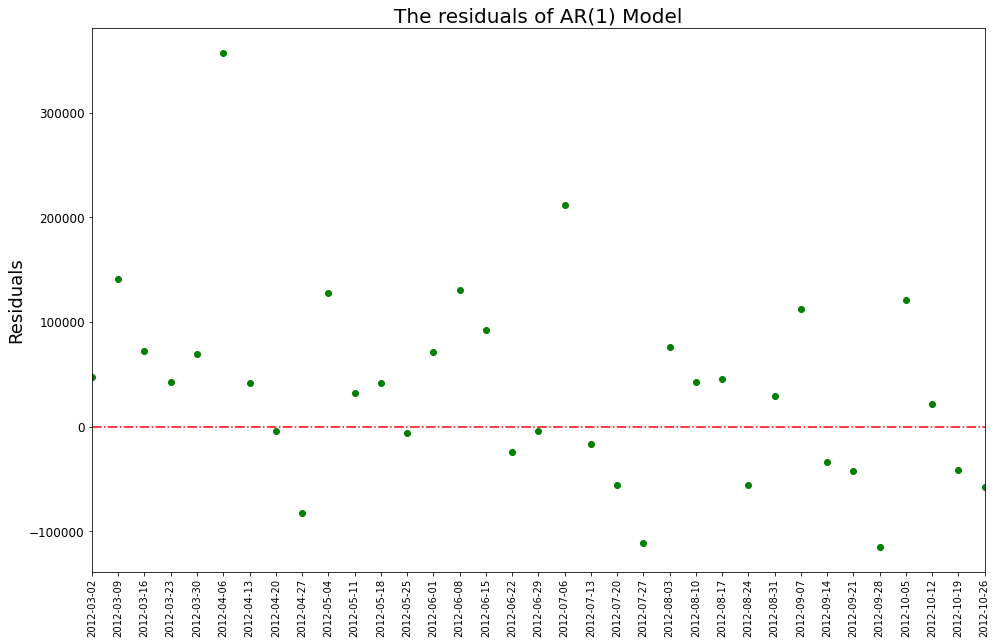

In [22]:
plt.figure(figsize=(16,10)) # figure size
# Creat residuals plot
plt.scatter(test['Weekly_Sales'].index, test['Weekly_Sales'].values - pred['Weekly Sales'].values, c ='green')

# Make a line at y=0
plt.hlines(y = 0, xmax = test['Weekly_Sales'].index.max(),xmin = test['Weekly_Sales'].index.min(), colors= 'red', linestyles = 'dashdot')

# Set labels and axes.
plt.xticks(fontsize=10, rotation=90)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=12)
plt.ylabel('Residuals', fontsize = 18)
plt.title("The residuals of AR(1) Model", fontsize=20)

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:
- In some days before June 29, the predictions are more than others and in later days the residuals closer to y=0 that means the true and the predicted values are closer to each other.

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [23]:
# Fit of the AR(2) model
train_values2 = train['Weekly_Sales'].values
train_dates2 = train.index

# The predictions start and end dates 
start = test.index[2]
end = test.index[-1]
AR2 = ARIMA(endog = train_values2,dates = train_dates2, order = (2,0,0)).fit()

# Find the predictions
AR2_pred = AR2.predict(start = start, end = end)
AR2_pred

# Test values and dates in the datasets.
test_values2 = test['Weekly_Sales'].values
test_dates2  = test.index

In [24]:
# Make evaluate of the train MSE from the datasets 
Train_MSE2=mean_squared_error(train_values2, AR2.predict())
Train_MSE2

25669024679.477707

In [25]:
# Make evaluate of the test MSE from the datasets
Test_MSE2=mean_squared_error(test_values2, AR2_pred)
Test_MSE2

11333863107.474178

Text(0.5, 1.0, 'The residuals of AR(2) Model')

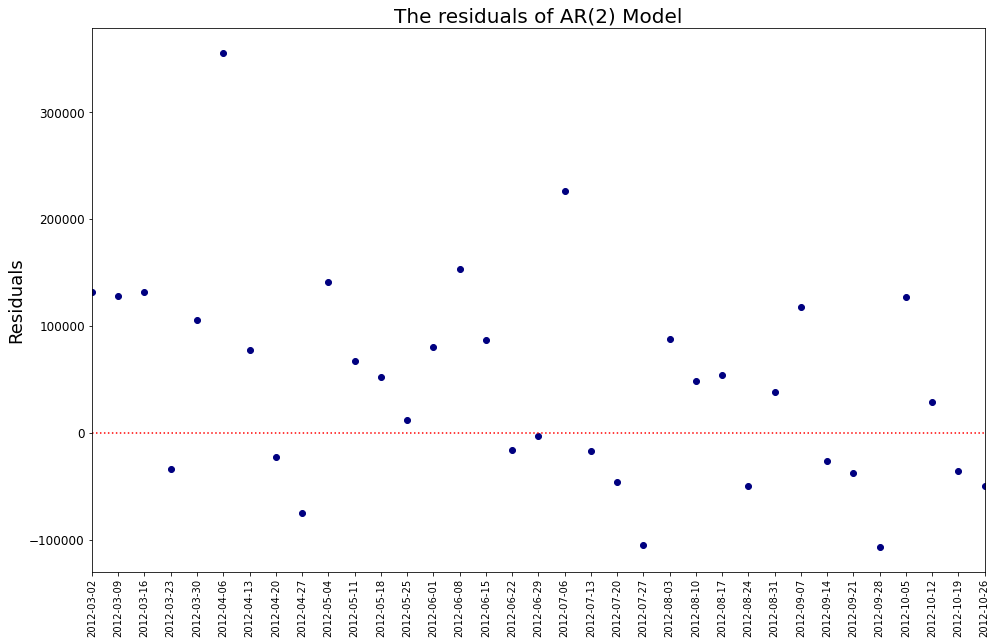

In [26]:
#Create Dataframe for the predicted values and make residuals plot
pred2 = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])
pred2

plt.figure(figsize=(16,10)) # figure size
# Creat residuals plot
plt.scatter(test['Weekly_Sales'].index, test['Weekly_Sales'].values - pred2['Weekly Sales'].values, c ='navy')

# Make a line at y=0
plt.hlines(y = 0, xmax = test['Weekly_Sales'].index.max(),xmin = test['Weekly_Sales'].index.min(), colors= 'red', linestyles = 'dotted')

# Set labels and axes.
plt.xticks(fontsize=10, rotation=90)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=12)
plt.ylabel('Residuals', fontsize = 18)
plt.title("The residuals of AR(2) Model", fontsize=20)

**8b. How did your results change?**

Answer:
- The results is not better than AR(1). It seems the model shows little variation in the sales predictions.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [27]:
# Fit of the ARMA(2,2) model
train_values22 = train['Weekly_Sales'].values
train_dates22 = train.index

# The predictions start and end dates 
start = test.index[2]
end = test.index[-1]
ARIMA22= ARIMA(endog = train_values22,dates = train_dates22, order = (2,0,0)).fit()

# Find the predictions
ARIMA22_pred = ARIMA22.predict(start = start, end = end)
ARIMA22_pred

pred22 = pd.DataFrame(ARIMA22_pred, index=date_list, columns = ['Weekly Sales'])
pred22;

Text(0.5, 1.0, 'The residuals of ARIMA(2, 2) Model')

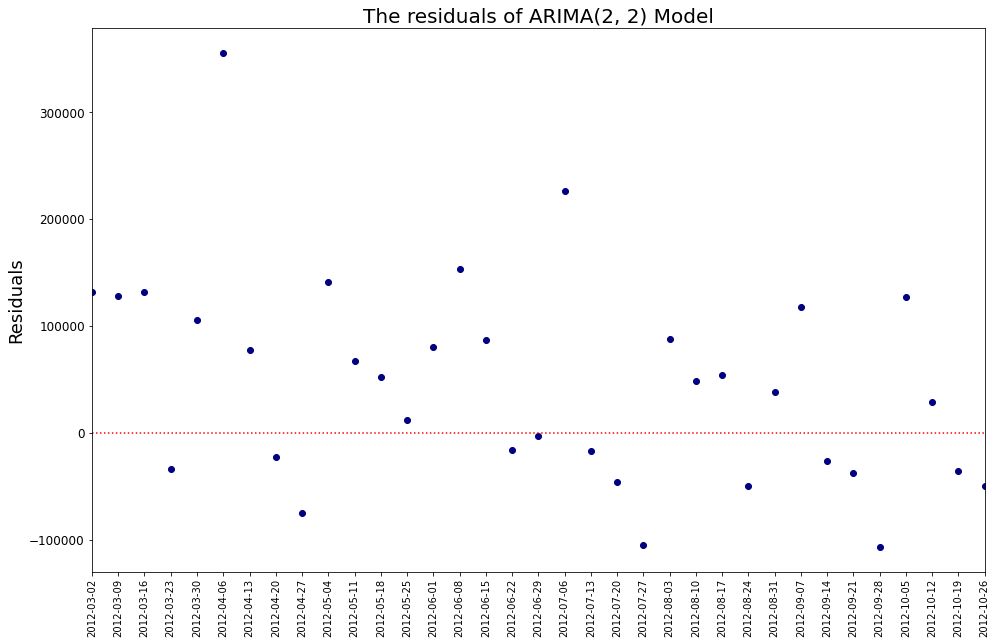

In [28]:
#Create Dataframe for the predicted values and make residuals plot
plt.figure(figsize=(16,10)) # figure size
# Creat residuals plot
plt.scatter(test['Weekly_Sales'].index, test['Weekly_Sales'].values - pred22['Weekly Sales'].values, c ='navy')

# Make a line at y=0
plt.hlines(y = 0, xmax = test['Weekly_Sales'].index.max(),xmin = test['Weekly_Sales'].index.min(), colors= 'red', linestyles = 'dotted')

# Set labels and axes.
plt.xticks(fontsize=10, rotation=90)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=12)
plt.ylabel('Residuals', fontsize = 18)
plt.title("The residuals of ARIMA(2, 2) Model", fontsize=20)

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer:
- The residuals doesn’t look better than `AR(1)` model in both in both `AR(2)` and `ARMA(2,2)` models.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [29]:
#  The codes are partly developed both from the course materials and https://machinelearningmastery.com/time-series-data-stationary-python/
def dickey_fuller(xx):
    xx = xx.dropna()
    print('\t\t\033[1mResults of Dickey-Fuller Test\033[0m\n\n')
    df_test = adfuller(xx, maxlag=0, autolag=None)
    
    print(f'Test Statistic \t\t\t\t {round(df_test[0],3)}')
    print(f'p-value \t\t\t\t {df_test[1]}')
    print(f'Lags Used \t\t\t\t {round(df_test[2],3)}')
    print(f'Number of Observations \t\t\t {round(df_test[3],3)}')
    
    for key, value in df_test[4].items():
        print(f'Critical Value {key} \t\t\t {round(value, 3)}')

In [30]:
dickey_fuller(train['Weekly_Sales'])

		Results of Dickey-Fuller Test


Test Statistic 				 -7.464
p-value 				 5.277167250610254e-11
Lags Used 				 0
Number of Observations 			 107
Critical Value 1% 			 -3.493
Critical Value 5% 			 -2.889
Critical Value 10% 			 -2.581


**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:
- The value of $p \approx 5.27\times 10^{-11} < 0.05 = \alpha$). This favor for accepting $H_A$ of the data are stationery and reject $H_0$ of the data are not stationary to fit the ARIMA model without any significant difference.

#### 10. Differenced Data

Regardless of what you found above, now we're going to take a look at differenced data.

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [31]:
# Create new columns in your Weekly_Sales dataframe
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff()
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(2)
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(3)
Weekly_Sales.head()

,Weekly_Sales,diff_1,diff_2,diff_3
Date,,,,
2010-02-05,1643690.90,NaN,NaN,NaN
2010-02-12,1641957.44,-1733.46,NaN,NaN
2010-02-19,1611968.17,-29989.27,-31722.73,NaN
2010-02-26,1409727.59,-202240.58,-232229.85,-233963.31
2010-03-05,1554806.68,145079.09,-57161.49,-87150.76


**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [32]:
print('Actual Data')
print('--------------------')
dickey_fuller(Weekly_Sales['Weekly_Sales'])
print('---------------------------')
for diff in range(1,4): # to create 1 to 3 diff
    print(f'Data Differenced by d = {diff}')
    print('---------------------')
    dickey_fuller(Weekly_Sales[f'diff_{diff}'])
    print('--------------------------------')

Actual Data
--------------------
		Results of Dickey-Fuller Test


Test Statistic 				 -8.669
p-value 				 4.5968274410764133e-14
Lags Used 				 0
Number of Observations 			 142
Critical Value 1% 			 -3.477
Critical Value 5% 			 -2.882
Critical Value 10% 			 -2.578
---------------------------
Data Differenced by d = 1
---------------------
		Results of Dickey-Fuller Test


Test Statistic 				 -17.501
p-value 				 4.3860500615947114e-30
Lags Used 				 0
Number of Observations 			 141
Critical Value 1% 			 -3.478
Critical Value 5% 			 -2.882
Critical Value 10% 			 -2.578
--------------------------------
Data Differenced by d = 2
---------------------
		Results of Dickey-Fuller Test


Test Statistic 				 -10.214
p-value 				 5.551624171727065e-18
Lags Used 				 0
Number of Observations 			 140
Critical Value 1% 			 -3.478
Critical Value 5% 			 -2.882
Critical Value 10% 			 -2.578
--------------------------------
Data Differenced by d = 3
---------------------
		Results of Dickey-Fuller Te

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:
- The data seem to be stationary for all the cases since it shows very low values of p_values and ttest difference are closer to zero.

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:
- Even though the data looks stationery, it may be better to use an ARIMA if the test has significant differenced values. 

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Using whichever metric(s) you think best suit this problem (don't forget to import them above!), evaluate your model on the training and testing sets and generate a residual plot.**

In [34]:
# Let's try to fit the model at d =0 if there any improvement

ARIMA_2_0_2 = ARIMA(endog = train_values, dates = train_dates, order = (2,0,2)).fit()

ARIMA_2_0_2_pred = ARIMA_2_0_2.predict(start=start, end = end)

mean_squared_error(test_values, ARIMA_2_0_2_pred)

11347816587.652739

In [33]:
# Let's try to fit the model at d =1 if there any improvement

ARIMA_2_1_2 = ARIMA(endog = train_values, dates = train_dates, order = (2,1,2)).fit()

ARIMA_2_1_2_pred = ARIMA_2_1_2.predict(start=start, end = end)

mean_squared_error(test_values, ARIMA_2_1_2_pred)

2531213120759.837

In [35]:
# Let's try to fit the model at d =2 if there any improvement

ARIMA_2_2_2 = ARIMA(endog = train_values, dates = train_dates, order = (2,2,2)).fit()

ARIMA_2_2_2_pred = ARIMA_2_2_2.predict(start=start, end = end)

mean_squared_error(test_values, ARIMA_2_2_2_pred)

2513635609518.0874

**11b. Interpret the results from the last answer.**


Answer:
- It gives lower error value at d =0, d =1, and 2 using ARIMA models. The value d=0 may help to operate closer to the actual fitting of the model.

### 13. Your Best Model

**13a. How did you decide this was your best model? How does your model perform at predicting weekly sales moving forward? Please use the metrics/visuals you included above to support your answer.** 

In [39]:
# It may be good to look seasonal ARIMA for selecting best model
sarima_model = SARIMAX(endog = train['Weekly_Sales'], order = (2, 0, 2), seasonal_order = (0, 1, 0, 70)).fit()

sarima_pred = sarima_model.predict(start=test.index[0], end = test.index[-1])
sarima_pred

2012-03-02    1.394494e+06
2012-03-09    1.528546e+06
2012-03-16    1.511655e+06
2012-03-23    1.480097e+06
2012-03-30    1.949251e+06
2012-04-06    1.556596e+06
2012-04-13    1.677755e+06
2012-04-20    1.890891e+06
2012-04-27    2.390945e+06
2012-05-04    1.364397e+06
2012-05-11    1.445910e+06
2012-05-18    1.391546e+06
2012-05-25    1.326181e+06
2012-06-01    1.317817e+06
2012-06-08    1.606426e+06
2012-06-15    1.649281e+06
2012-06-22    1.687298e+06
2012-06-29    1.456540e+06
2012-07-06    1.636258e+06
2012-07-13    1.553350e+06
2012-07-20    1.576662e+06
2012-07-27    1.541166e+06
2012-08-03    1.495092e+06
2012-08-10    1.614194e+06
2012-08-17    1.559938e+06
2012-08-24    1.564809e+06
2012-08-31    1.455073e+06
2012-09-07    1.629415e+06
2012-09-14    1.604762e+06
2012-09-21    1.428218e+06
2012-09-28    1.466055e+06
2012-10-05    1.635070e+06
2012-10-12    1.588952e+06
2012-10-19    1.532116e+06
2012-10-26    1.438827e+06
Freq: W-FRI, Name: predicted_mean, dtype: float64

In [40]:
pred = pd.DataFrame(sarima_pred.values, index=date_list, columns = ['Weekly Sales'])

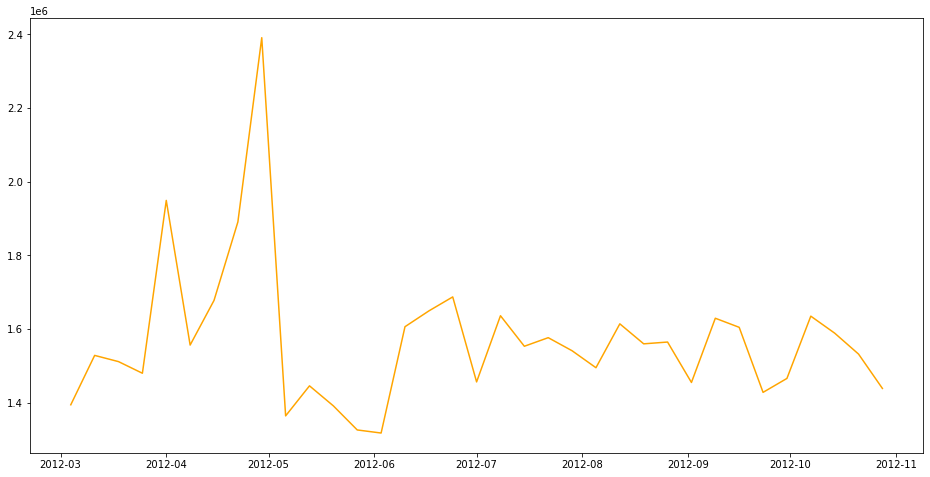

In [41]:
plt.figure(figsize=(16, 8))
plt.plot(pred, c='orange');

Answer: 

**13b. How might you improve this model?**

Answer:
- It requires more data to see with different years to fix the residual errors off predictions places and highly spiked time. 